In [1]:
from bs4 import BeautifulSoup
from collections import Counter
from collections import defaultdict
from io import BytesIO
import math
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag as word_type
import numpy as np
import pandas as pd
from PIL import Image
import pytesseract
import re
import requests
import string

In [2]:
df = pd.read_csv("./data/companies_to_productize.csv", encoding="ISO-8859-1", dtype=str)
categories = []

with open("saved_productization_results.txt", "r") as f:
    for line in f.readlines():
        categories.append(line)
df["products"] = categories

import ast

def find_top_product(products):
    classification = ast.literal_eval(products)["results"]
    
    if len(classification) > 0:
        # only grab the top product category
        # most_specific = classification[0][0].split("> ")[-1]
        # return most_specific
        results = []
        for product in classification:
            # grab the most specific product category for each of the results
            # results.append((product[0].split(">")[-1].strip(), product[1]))
            results.append((product[0], product[1]))
        return results
    else:
        return None
    

df["product_scores"] = df["products"].apply(lambda x: find_top_product(x))

In [3]:
def aggregate_company_scores(emails):

    company_categories = {}
    
    for email_score in emails["product_scores"]:
        if email_score != None:
            for score in email_score:
                product = score[0]
                value = score[1]
                
                if product in company_categories:
                    company_categories[product] = company_categories[product] + value
                else:
                    company_categories[product] = value
    categories = list(company_categories.items())
    categories.sort(key=lambda tup: tup[0])
    return(categories)
        
    

companies = df.groupby("name")
dataframe_arr = []

for company, group in companies:    
    score = aggregate_company_scores(group)
    for s in score:
        dataframe_arr.append({"company": company.split(" ")[0], "label": s[0], "score": s[1]})

score_df = pd.DataFrame(dataframe_arr)

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


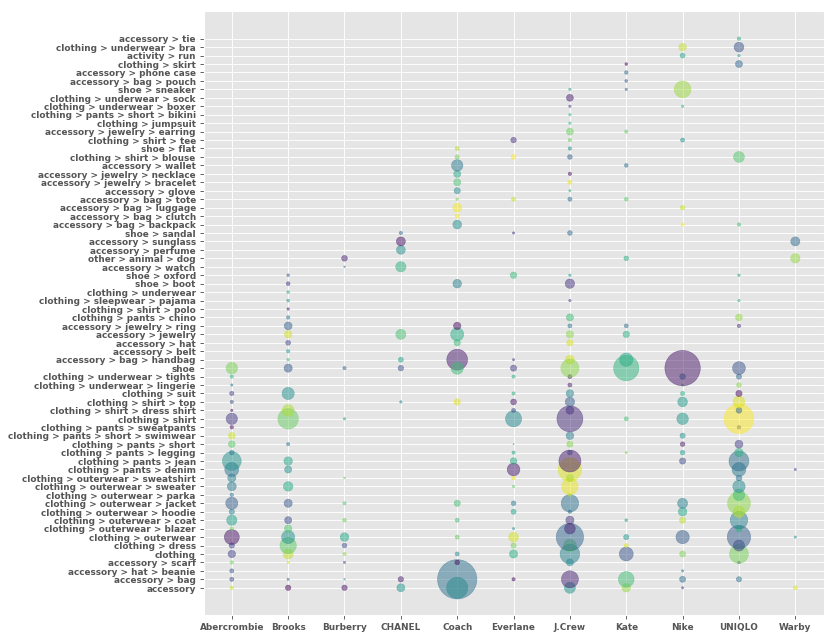

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = score_df["company"].values
y = score_df["label"].values
size = score_df["score"].values * 10

font = {'family' : 'helvetica',
        'weight' : 'bold',
        'size'   : 8}

plt.rc('font', **font)
plt.figure(figsize=(10, 10), dpi= 80)
plt.scatter(x, y, s=size, c=np.random.rand(len(x)), alpha=0.5)
plt.show()

In [ ]:
# [x] this email is like that email
# [x] this company is like that company

# using google vision to build the categories
# removing noise: discard low-value categories
# give points to lower categories
# color bubbles based on top-level category

## Other ideas
# build our own keras model
## we would need training data for each category

In [29]:
# this company is like that company

from sklearn.cluster import KMeans


pivot_df = score_df.pivot(index="company", values="score", columns="label").fillna(0)
kmeans = KMeans(n_clusters=4, random_state=100).fit(pivot_df)

In [45]:
for i, val in enumerate(kmeans.labels_):
    print(pivot_df.index[i], ": ", val)

Abercrombie :  2
Brooks :  2
Burberry :  2
CHANEL :  2
Coach :  0
Everlane :  2
J.Crew :  3
Kate :  1
Nike :  1
UNIQLO :  3
Warby :  2


In [61]:
from sklearn.metrics.pairwise import cosine_similarity

company_similarity_matrix = pd.DataFrame(cosine_similarity(pivot_df, pivot_df))
company_similarity_matrix.columns = list(pivot_df.index)
company_similarity_matrix.index = list(pivot_df.index)
company_similarity_matrix

,Abercrombie,Brooks,Burberry,CHANEL,Coach,Everlane,J.Crew,Kate,Nike,UNIQLO,Warby
Abercrombie,1.000000,0.530510,0.467505,0.048685,0.069413,0.624969,0.859448,0.271778,0.366393,0.781521,0.037397
Brooks,0.530510,1.000000,0.448068,0.080337,0.056147,0.767647,0.740222,0.192575,0.235209,0.783039,0.023103
Burberry,0.467505,0.448068,1.000000,0.136555,0.132308,0.330151,0.583194,0.223556,0.245895,0.500881,0.338721
CHANEL,0.048685,0.080337,0.136555,1.000000,0.314349,0.028034,0.116819,0.271930,0.153138,0.024437,0.314947
Coach,0.069413,0.056147,0.132308,0.314349,1.000000,0.053081,0.258035,0.479128,0.118790,0.050347,0.035920
Everlane,0.624969,0.767647,0.330151,0.028034,0.053081,1.000000,0.827512,0.192930,0.250144,0.814813,0.033602
J.Crew,0.859448,0.740222,0.583194,0.116819,0.258035,0.827512,1.000000,0.382402,0.374485,0.868516,0.051245
Kate,0.271778,0.192575,0.223556,0.271930,0.479128,0.192930,0.382402,1.000000,0.846506,0.211566,0.036808
Nike,0.366393,0.235209,0.245895,0.153138,0.118790,0.250144,0.374485,0.846506,1.000000,0.300753,0.006652
UNIQLO,0.781521,0.783039,0.500881,0.024437,0.050347,0.814813,0.868516,0.211566,0.300753,1.000000,0.024121


In [102]:
# this email like that email

def grab_email_scores(email):
    
    company_categories = {}
        
    email_score = email["product_scores"]
    if email_score != None:
        for score in email_score:
            product = score[0]
            value = score[1]

            if product in company_categories:
                company_categories[product] = company_categories[product] + value
            else:
                company_categories[product] = value
    categories = list(company_categories.items())

    result = []
    for cat in categories:
        result.append([email["name"], email.guid, cat[0], cat[1]])
    return(result)


emails = []
for index, row in df.iterrows():
    emails.extend(grab_email_scores(row))

emails_df = pd.DataFrame(emails, columns=["company", "guid", "category", "score"])

In [104]:
email_pivot = emails_df.pivot(index="guid", columns="category", values="score").fillna(0)

In [107]:
email_similarity_matrix = pd.DataFrame(cosine_similarity(email_pivot, email_pivot))
email_similarity_matrix.columns = list(email_pivot.index)
email_similarity_matrix.index = list(email_pivot.index)
email_similarity_matrix.loc["013864ed-ff3d-ebab-ed15-29bd2c852755"].sort_values(ascending=False)


013864ed-ff3d-ebab-ed15-29bd2c852755    1.000000
a1dcc6c6-8150-78f2-1a2c-b16bbe92a8ed    0.802275
88df7b42-a0e8-daaf-7f04-0bbb7673bfa8    0.802275
a793621d-b18d-e717-9c5b-101c8d705b2e    0.799432
ed1a5ec5-3a92-653b-7d70-8aef30ede653    0.799432
92b6abad-40b6-353b-91f0-f5edc582ddd6    0.799432
f22220c5-0d41-9a85-dc5c-a987c4c69cfe    0.786539
dbcbff28-a4da-aaff-54c0-175e26b442dd    0.786539
2e8dbcf6-d8c7-d0f6-9cf5-a43793c71600    0.782804
ff99b23e-2511-0e5e-a4f2-9231531fbd89    0.780693
569afaf5-abf4-abdc-bb57-e7dc0cc072d1    0.780693
5cdb1471-6b48-e098-b837-0711e439f013    0.780693
61864a3e-aea8-b829-5d2b-3c51fb3b4c37    0.779202
ea4469e2-a87b-2256-8041-7613ea94d985    0.779202
d536d3ff-042d-3bc1-72f7-187ee2db03ea    0.779202
421e70be-5b9a-bb7b-014c-9bd4fc250454    0.779202
0a7db015-42ab-1856-ad8f-658d1d6097af    0.779202
c4b4e9c6-be77-32a9-8a47-0bbb6b8a351b    0.779202
c5f7b5b8-e886-e229-e770-a40b5b8f8500    0.779202
54be5e31-dd78-1322-996d-d88d3df9c849    0.779202
132fe289-6db4-9758-5

In [130]:
from sklearn.metrics.pairwise import cosine_similarity

def find_first_non_company_email(guid):
    emails = email_similarity_matrix.loc[guid].sort_values(ascending=False).index
    company = emails_df[emails_df["guid"] == guid]["company"].iloc[0]

    for email in emails:
        email_company = emails_df[emails_df["guid"] == email]["company"].iloc[0]
        if company != email_company:
            return email

find_first_non_company_email("1b839bba-c8b6-0289-5d30-fc145bd57b34")

'2d390a9c-9c7e-0752-301b-558e3f4afd6f'